# Unit 2 Project

The case of customersâ€™ default payments in Taiwan. 


**IMPORTS AND INSTALLS**

In [1]:
%%capture
import sys

# Colab Path:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# Local Path:
else:
    DATA_PATH = '../data/'

In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve

# pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor

# Permutation Importance
from sklearn.inspection import permutation_importance 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded = files.upload()

Saving default of credit card clients.csv to default of credit card clients.csv


**WRANGLE FUNCTION:**

In [4]:
import io

filepath = 'default of credit card clients.csv'

def wrangle(filepath):
  df = pd.read_csv(io.BytesIO(uploaded[filepath]),
                 index_col = 'ID')
  
  # Rename columns
  df.rename(columns={'default payment next month': 'default',
                     'PAY_0': 'PAY_1'}, inplace=True)
  
  # Reduce unknown values to other category
  extra = (df['EDUCATION'] == 0) | (df['EDUCATION'] == 6) | (df['EDUCATION'] == 5)
  df.loc[extra, 'EDUCATION'] = 4

  extra_2 = (df['MARRIAGE'] == 0)
  df.loc[extra_2, 'MARRIAGE'] = 3

  return df

df = wrangle(filepath)

In [5]:
print(df.shape)
df.head()

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [7]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [8]:
# from pandas_profiling import ProfileReport

# report = ProfileReport(df, minimal=True).to_notebook_iframe() 

**SPLIT DATA**

In [9]:
target = 'default'
y = df[target]
X = df.drop(columns=target)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

**BASELINE**

In [12]:
# Baseline Metric
print('The baseline accuracy is ', y_train.value_counts(normalize=True).max())

The baseline accuracy is  0.7773888888888889


**RANDOM OVERSAMPLING:**

In [13]:
print(df['default'].value_counts())

df_majority = df[df['default']==0]
df_minority = df[df['default']==1]

print(df_majority.value_counts().sum(), df_minority.value_counts().sum())

0    23364
1     6636
Name: default, dtype: int64
23364 6636


In [14]:
from sklearn.utils import resample

df_minority_oversampling = resample(df_minority,
                                    replace=True,
                                    n_samples=23364,
                                    random_state=42)

In [15]:
df_oversample = pd.concat([df_majority, df_minority_oversampling])

In [16]:
print('New class distribution:')
df_oversample['default'].value_counts()

New class distribution:


1    23364
0    23364
Name: default, dtype: int64

**SPLIT DATA OF THE NEW OVERSAMPLED DATAFRAME (df_oversample):**

In [17]:
target = 'default'
y = df_oversample[target]
X = df_oversample.drop(columns=target)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

**CHECK THE BASELINE OF THE OVERSAMPLED DATA**

In [20]:
# Baseline Metric
print('The oversampled baseline accuracy is ', y_train.value_counts(normalize=True).max())

The oversampled baseline accuracy is  0.5015337423312883


**BUILD MODELS -- LOGISTIC REGRESSION**

In [21]:
model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

model_logr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
# Models for Shapely plots

# model_logr = LinearRegression()
# model_logr.fit(X_train, y_train)

In [22]:
print('LOGR Training Accuracy:', model_logr.score(X_train, y_train))
print('LOGR Validation Accuracy:', model_logr.score(X_val, y_val))

LOGR Training Accuracy: 0.6751676416036525
LOGR Validation Accuracy: 0.6701262572223411


**BUILD MODELS -- RANDOM FOREST**

In [23]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [58]:
# Models for Shapely plots

model_rf = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [24]:
print('RF Training Accuracy:', model_rf.score(X_train, y_train))
print('RF Validation Accuracy:', model_rf.score(X_val, y_val))

RF Training Accuracy: 0.9995363104579826
RF Validation Accuracy: 0.9144018831585705


**BUILD MODELS -- XGBOOST**

In [25]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_estimators=100, n_jobs=-1) 
)

model_xgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier', XGBClassifier(n_jobs=-1, random_state=42))])

In [ ]:
# Removing the pipeline from the model for Shapley Plots

# model_xgb = XGBClassifier(n_jobs=-1, random_state=42, n_estimators=100)

# model_xgb.fit(X_train, y_train)

In [26]:
print('XGB Training Accuracy', model_xgb.score(X_train, y_train))
print('XGB Validation Accuracy', model_xgb.score(X_val, y_val))

XGB Training Accuracy 0.7290269653302897
XGB Validation Accuracy 0.7207361438048363


**CHECK METRICS - ROC CURVES & AUC SCORES:**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.wa

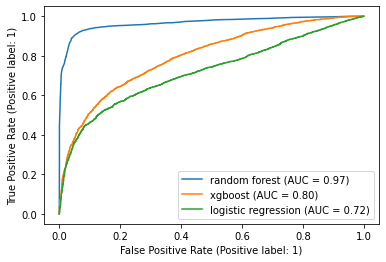

In [27]:
# ROC Curves & AUC scores

rf = plot_roc_curve(model_rf,
               X_val,
               y_val,
               name="random forest");
xgb = plot_roc_curve(model_xgb,
               X_val,
               y_val,
               ax=rf.ax_,
               name="xgboost");
logr = plot_roc_curve(model_logr,
                      X_val,
                      y_val,
                      ax=rf.ax_,
                      name="logistic regression");

In [28]:
roc_auc_score(y_val, model_logr.predict_proba(X_val)[:,-1])

0.7195897460561755

In [29]:
roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,-1])

0.9660214093332602

In [30]:
roc_auc_score(y_val, model_xgb.predict_proba(X_val)[:,-1])

0.7970454982685649

**TEST SCORE:**

In [31]:
# ROC AUC Score on the Test data:

roc_auc_score(y_test, model_rf.predict_proba(X_test)[:,-1])

0.9630326558001916

**HYPER-PARAMETER TUNING**

In [36]:
# Tune LR

clf = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LogisticRegression(random_state=42, n_jobs=-1)
)

param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'logisticregression__penalty' : ['l2', 'none'],
    'logisticregression__max_iter': range(25, 225, 50)
}

model_rfrs = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter = 10
)

model_rfrs.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(use_cat_names=True)),
                                             ('simpleimputer', SimpleImputer()),
                                             ('logisticregression',
                                              LogisticRegression(n_jobs=-1,
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__max_iter': range(25, 225, 50),
                                        'logisticregression__penalty': ['l2',
                                                                        'none'],
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   verbose=1)

In [37]:
model_rfrs.best_params_

{'logisticregression__max_iter': 125,
 'logisticregression__penalty': 'none',
 'simpleimputer__strategy': 'median'}

In [38]:
model_rfrs.best_score_

0.6127381447581401

In [40]:
# Tune RF 

clf_2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

param_grid_2 = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth' : range(5, 105, 20),
    'randomforestclassifier__n_estimators': range(50, 1150, 100)
}

model_rfrs_2 = RandomizedSearchCV(
    clf_2,
    param_distributions = param_grid_2,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter = 10
)

model_rfrs_2.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 105, 20),
                                        'randomforestclassifier__n_estimators': range(50, 1150, 100),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   verbose=1)

In [41]:
model_rfrs_2.best_params_

{'randomforestclassifier__max_depth': 45,
 'randomforestclassifier__n_estimators': 850,
 'simpleimputer__strategy': 'mean'}

In [42]:
model_rfrs_2.best_score_

0.934536355555983

**FEATURE IMPORTANCES:**

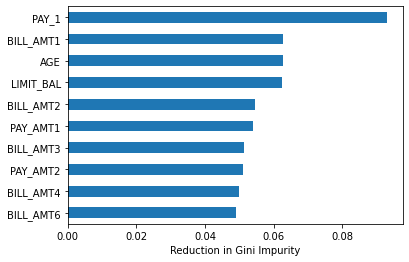

In [44]:
bestimator = model_rfrs_2.best_estimator_
importances = bestimator.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

In [45]:
# Get predicted probabilities from RF model
y_pred_proba = model_rf.predict_proba(X_val)[:, -1]

# Input true labels and probability predictions 
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Put data into dictionary
data = {
    'fpr':fpr,
    'tpr':tpr,
    'threshold':thresholds
}

pd.DataFrame(data)

,fpr,tpr,threshold
0,0.000000,0.000000,2.000000
1,0.000435,0.149600,1.000000
2,0.000435,0.241677,0.990000
3,0.000435,0.242309,0.982137
4,0.000435,0.320059,0.980000
...,...,...,...
161,0.978261,0.999368,0.040000
162,0.986739,1.000000,0.030000
163,0.993913,1.000000,0.020000
164,0.997826,1.000000,0.010000


In [ ]:
# Find the threshold that gives the highest tpr + lowest fpr...

**CLASSIFICATION REPORT**

In [46]:
from sklearn.metrics import classification_report

model_cr = classification_report(y_val, model_rf.predict(X_val))

print(model_cr)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      4600
           1       0.90      0.94      0.92      4746

    accuracy                           0.91      9346
   macro avg       0.92      0.91      0.91      9346
weighted avg       0.92      0.91      0.91      9346



**CONFUSION MATRIX:**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


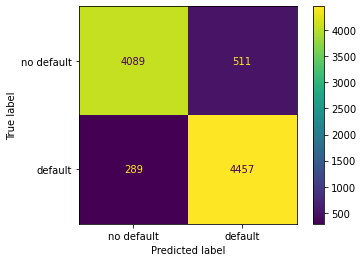

In [47]:
# confusion matrix 

plot_confusion_matrix(
    model_rf,
    X_val,
    y_val,
    values_format='.0f',
    display_labels=['no default', 'default'] 
);

In [48]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

**PERMUTATION IMPORTANCES:**

In [49]:
col = 'PAY_1'

In [50]:
model_perm = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)  
)

model_perm.fit(X_train, y_train)

print(f'Validation Accuracy w/ "{col}" included:', model_perm.score(X_val, y_val))

Validation Accuracy w/ "PAY_1" included: 0.9144018831585705


In [51]:
X_val_perm = X_val.copy()
X_val_perm[col] = np.random.permutation(X_val_perm[col])

In [52]:
model_perm.score(X_val_perm, y_val)

0.804729295955489

In [53]:
perm_imp = permutation_importance(model_perm, X_val, y_val, random_state=42)

In [54]:
data_perm = {'imp_mean': perm_imp['importances_mean'],
             'imp_std': perm_imp['importances_std']}

df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [55]:
df_perm

,imp_mean,imp_std
PAY_5,-0.000021,0.000647
BILL_AMT4,0.001006,0.001065
SEX,0.003317,0.000395
PAY_6,0.003745,0.000818
BILL_AMT5,0.004066,0.000933
BILL_AMT3,0.004066,0.000853
PAY_4,0.004387,0.000925
MARRIAGE,0.004708,0.000775
PAY_3,0.004900,0.000743
BILL_AMT6,0.006291,0.000841


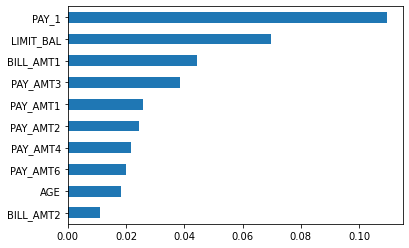

In [56]:
df_perm['imp_mean'].tail(10).plot(kind='barh') 

**PDP PLOTS:**

In [57]:
# Visualizations
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

**Had to go back and rerun my rf_model without a pipeline before plotting below....**

In [59]:
feature = 'PAY_1'

isolate = pdp_isolate(
    model_rf,
    dataset=X_val,
    model_features = X_val.columns,
    feature = feature
)

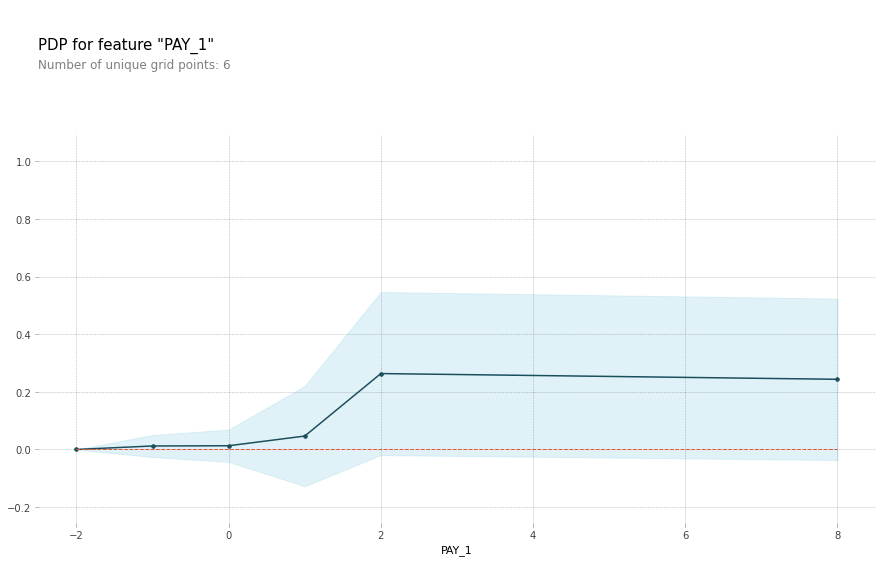

In [61]:
pdp_plot(isolate, feature_name=feature);

In [62]:
isolate.percentile_info

array(['(0.0)', '(11.11, 22.22)', '(33.33, 44.44, 55.56, 66.67)',
       '(77.78)', '(88.89)', '(100.0)'], dtype=object)

**Two Features:**

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


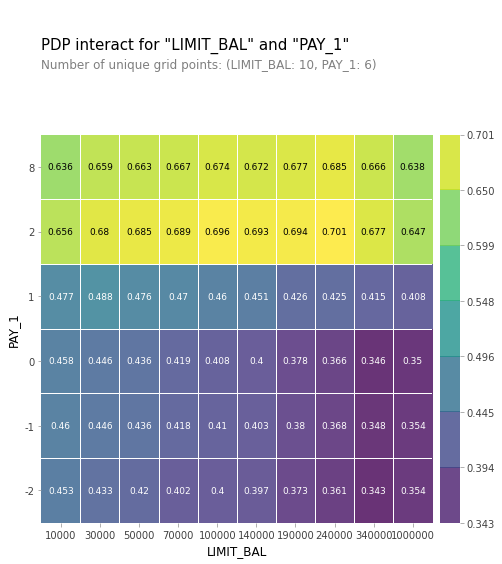

In [63]:
features = ['LIMIT_BAL', 'PAY_1']

interact = pdp_interact(
    model_rf,
    dataset=X_val,
    model_features = X_val.columns,
    features = features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

**SHAPLEY PLOTS:**

In [64]:
sample_row = X_val.tail(1)

In [65]:
sample_row

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,
11809,50000,2,3,1,55,0,0,0,0,2,0,46300,10849,8857,9658,9359,9554,1200,1147,1222,0,350,338


In [66]:
explainer = shap.TreeExplainer(model_rf)
shap_value = explainer.shap_values(sample_row)

In [68]:
# you may need to install somethign called ipywidgets
# import ipywidgets as widgets

shap.initjs()

shap.force_plot(
    base_value = explainer.expected_value[0],
    shap_values = shap_value[0],
    features = sample_row
)

In [70]:
np.shape(shap_value)

(2, 1, 23)

In [72]:
shap_value = np.transpose(shap_value)

In [73]:
shap_value.shape

(23, 1, 2)

In [77]:
# Commenting my shapley waterfall plot out since I have a dimension error

# shap_df = pd.DataFrame(data=shap_value[1], index=X_val.columns, columns=['shap_value'])

In [78]:
# shap_df.sort_values(by='shap_value', ascending=False)

In [79]:
# shap_df['shap_value'].sum() + _._

In [80]:
# Shapley waterfall plot

# explainer = shap.TreeExplainer(model_rf)
# shap_values = explainer(sample_row)
# shap.plots.waterfall(shap_values[0])